In [8]:
%load_ext autoreload
%autoreload 2

import visualization.plot_3d_global as plot_3d
from data_generation import *
import numpy as np
from utils.rotation_conversions import *
# from smpl2bvh.smpl2bvh import *
import os
import torch
# import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# import os
# os.chdir('VQ-Trans')
import sys
sys.argv = ['GPT_eval_multi.py']
import options.option_transformer as option_trans
args = option_trans.get_args_parser()

args.dataname = 't2m'
args.resume_pth = 'pretrained/VQVAE/net_last.pth'
args.resume_trans = 'pretrained/VQTransformer_corruption05/net_best_fid.pth'
args.down_t = 2
args.depth = 3
args.block_size = 51
import clip
import torch
import numpy as np
import models.vqvae as vqvae
import models.t2m_trans as trans
## load clip model and datasets
clip_model, clip_preprocess = clip.load("ViT-B/32", device=torch.device('cuda'), jit=False, download_root='./')  # Must set jit=False for training
clip.model.convert_weights(clip_model)  # Actually this line is unnecessary since clip by default already on float16
clip_model.eval()
for p in clip_model.parameters():
    p.requires_grad = False

net = vqvae.HumanVQVAE(args, ## use args to define different parameters in different quantizers
                       args.nb_code,
                       args.code_dim,
                       args.output_emb_width,
                       args.down_t,
                       args.stride_t,
                       args.width,
                       args.depth,
                       args.dilation_growth_rate)


trans_encoder = trans.Text2Motion_Transformer(num_vq=args.nb_code, 
                                embed_dim=1024, 
                                clip_dim=args.clip_dim, 
                                block_size=args.block_size, 
                                num_layers=9, 
                                n_head=16, 
                                drop_out_rate=args.drop_out_rate, 
                                fc_rate=args.ff_rate)


print ('loading checkpoint from {}'.format(args.resume_pth))
ckpt = torch.load(args.resume_pth, map_location='cpu')
net.load_state_dict(ckpt['net'], strict=True)
net.eval()
net.cuda()

print ('loading transformer checkpoint from {}'.format(args.resume_trans))
ckpt = torch.load(args.resume_trans, map_location='cpu')
trans_encoder.load_state_dict(ckpt['trans'], strict=True)
trans_encoder.eval()
trans_encoder.cuda()

mean = torch.from_numpy(np.load('./checkpoints/t2m/VQVAEV3_CB1024_CMT_H1024_NRES3/meta/mean.npy')).cuda()
std = torch.from_numpy(np.load('./checkpoints/t2m/VQVAEV3_CB1024_CMT_H1024_NRES3/meta/std.npy')).cuda()

loading checkpoint from pretrained/VQVAE/net_last.pth
loading transformer checkpoint from pretrained/VQTransformer_corruption05/net_best_fid.pth


In [10]:
clip_text = ['A woman walks counterclockwise.']
vis = True
vis_file = 'test_vis.gif'

text = clip.tokenize(clip_text, truncate=True).cuda()
feat_clip_text = clip_model.encode_text(text).float()
index_motion = trans_encoder.sample(feat_clip_text[0:1], False)
pred_pose = net.forward_decoder(index_motion)

from utils.motion_process import recover_from_ric
pred_xyz = recover_from_ric((pred_pose*std+mean).float(), 22)
xyz = pred_xyz.reshape(1, -1, 22, 3)

if vis:
    import visualization.plot_3d_global as plot_3d
    pose_vis = plot_3d.draw_to_batch(xyz.detach().cpu().numpy(),clip_text, [vis_file])

torch.Size([1, 156, 21, 3])
torch.Size([1, 156, 21, 4])


/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the fi

/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the fi

/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the fi

/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the fi

/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the fi

/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the fi

/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the fi

/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
/mnt/d/imu_gpt_private/visualization/plot_3d_global.py:59: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the fi

In [6]:
motion2bvh_ik(xyz.detach().cpu().numpy()[0], 'test_xyz_to_bvh.bvh')

[BasicInverseKinematics] Iteration 1 Error: 0.037417


In [11]:


# activities = [ 'walking counter-clockwise', 'walking clockwise', 'jumping']

activities = ['walking forward', 'walking counter-clockwise', 'walking clockwise', 'climbing up stairs',
              'climbing down stairs', 'running', 'jumping', 'sitting', 'standing', 'lying', 'riding up elevator',
             'riding down elevator']
motion_descriptions = ['The subject walks forward in a straight line',
                      'walking counter-clockwise in a full circle',
                      'walking clockwise in a full circle',
                      None,
                      None,
                      'The subject runs forward in a straight line',
                      'jummping rope',
                      'The subject sits on a chair either working or resting.',
                      'The subject stands and talks to someone',
                      None,
                      'The subject rides in an ascending elevator',
                      'The subject rides in a descending elevator']


vis_dir = 'vis_result'
dataset = 'usc-had_50'
vis = False
ik =True


num_repeats = 1
for act in activities:
    npy_dir = f'npy/{dataset}/{act}'
    smpl_dir = f'smpl/{dataset}/{act}'
    if ik:
        bvh_dir = f'bvh/{dataset}/ik/{act}'
        bvh_resize_dir = f'bvh_resized/{dataset}/ik/{act}'
    else:
        bvh_dir = f'bvh/{dataset}/smpl/{act}'
        bvh_resize_dir = f'bvh_resized/{dataset}/smpl/{act}'
    prompt_dir = f'prompts/{dataset}'
    
    vis_skeleton_dir = f'{vis_dir}/skeleton/{dataset}/{act}'
    vis_smpl_dir = f'{vis_dir}/smpl/{dataset}/{act}'
    os.makedirs(vis_skeleton_dir, exist_ok = True)
    os.makedirs(vis_smpl_dir, exist_ok = True)
    os.makedirs(npy_dir, exist_ok = True)
#     os.makedirs(smpl_dir, exist_ok = True)
    os.makedirs(bvh_dir, exist_ok = True)
    os.makedirs(bvh_resize_dir, exist_ok = True)
    
    # open the file for reading
    with open(f'{prompt_dir}/{act}.txt', 'r', errors='replace') as f:
      mylist = []
      for line in f:
        if '\ufffd' in line:
            print(line)
        else:
            mylist.append(line.strip())

    print(mylist)
    for i in range(len(mylist)):
        print(mylist[i])
        clip_text = [mylist[i]]
        print(clip_text)
        for j in range(num_repeats):
            name = f'{act}_{i}_{j}'
            print(name)
            
#             if os.path.exists(f'{bvh_dir}/{name}.bvh'):
# #                 print(f'{bvh_dir}/{name}.bvh')
#                 continue 
            text_to_bvh(clip_text, name, npy_dir, bvh_dir, bvh_resize_dir, f'{vis_skeleton_dir}/{name}.gif'
                        , clip_model, trans_encoder,net, std, mean, vis = vis)

['A woman confidently walks forward, keeping her eyes focused ahead.', 'The athlete briskly walks forward, aiming to beat their previous record.', 'A child joyfully walks forward, swinging their arms with each step.', 'The hiker steadily walks forward, taking in the breathtaking mountain view.', 'A businessman purposefully walks forward, clutching important documents.', 'The elderly man cautiously walks forward, using a cane for support.', 'A student absentmindedly walks forward while engrossed in a book.', 'The explorer boldly walks forward, venturing into uncharted territory.', "A couple leisurely walks forward, hand in hand, enjoying each other's company.", 'The marathon runner determinedly walks forward during a brief rest period.', 'A commuter hurriedly walks forward, determined to catch the next bus.', 'The park ranger vigilantly walks forward, protecting the wildlife within.', 'A tourist excitedly walks forward, eager to explore a new city.', 'The delivery person briskly walks f

torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.024972
MOTION

131
The fashion model confidently walks forward, showcasing the latest designs.
['The fashion model confidently walks forward, showcasing the latest designs.']
walking forward_17_0
torch.Size([1, 72, 21, 3])
torch.Size([1, 72, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.005703
MOTION

131
A soldier marches forward with discipline and precision.
['A soldier marches forward with discipline and precision.']
walking forward_18_0
torch.Size([1, 84, 21, 3])
torch.Size([1, 84, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.010026
MOTION

131
The jogger maintains a steady pace, walking forward to cool down after a run.
['The jogger maintains a steady pace, walking forward to cool down after a run.']
walking forward_19_0
torch.Size([1, 40, 21, 3])
torch.Size([1, 40, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.008043
MOTION

131
A nature enthusiast leisu

torch.Size([1, 168, 21, 3])
torch.Size([1, 168, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.021693
MOTION

131
A runner effortlessly moves forward, their muscles in sync.
['A runner effortlessly moves forward, their muscles in sync.']
walking forward_46_0
torch.Size([1, 72, 21, 3])
torch.Size([1, 72, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.006367
MOTION

131
The explorer walks forward, uncovering hidden treasures along their journey.
['The explorer walks forward, uncovering hidden treasures along their journey.']
walking forward_47_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.057498
MOTION

131
In a lively dance routine, performers step forward with rhythmic precision.
['In a lively dance routine, performers step forward with rhythmic precision.']
walking forward_48_0
torch.Size([1, 164, 21, 3])
torch.Size([1, 164, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.045273
MOTION

131
The commuter walk

torch.Size([1, 144, 21, 3])
torch.Size([1, 144, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.046049
MOTION

131
With a leisurely gait, a wanderer strolls leisurely in a counter-clockwise trajectory.
['With a leisurely gait, a wanderer strolls leisurely in a counter-clockwise trajectory.']
walking counter-clockwise_8_0
torch.Size([1, 80, 21, 3])
torch.Size([1, 80, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.031212
MOTION

131
In fluid motion, a figure walks in a sweeping counter-clockwise motion, never deviating.
['In fluid motion, a figure walks in a sweeping counter-clockwise motion, never deviating.']
walking counter-clockwise_9_0
torch.Size([1, 108, 21, 3])
torch.Size([1, 108, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.006649
MOTION

131
Silently and purposefully, a figure moves with precision around a counterclockwise circle.
['Silently and purposefully, a figure moves with precision around a counterclockwise circle.']
walking counter-clockwise_10_0
to

torch.Size([1, 128, 21, 3])
torch.Size([1, 128, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.030910
MOTION

131
In a calm rhythm, a woman walks counter-clockwise, encircling with each step.
['In a calm rhythm, a woman walks counter-clockwise, encircling with each step.']
walking counter-clockwise_33_0
torch.Size([1, 140, 21, 3])
torch.Size([1, 140, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.051630
MOTION

131
Flawlessly, a person glides counter-clockwise, flowing through the circular pathway.
['Flawlessly, a person glides counter-clockwise, flowing through the circular pathway.']
walking counter-clockwise_34_0
torch.Size([1, 76, 21, 3])
torch.Size([1, 76, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.025937
MOTION

131
With utmost grace, a man walks counterclockwise, encircling in a fluid motion.
['With utmost grace, a man walks counterclockwise, encircling in a fluid motion.']
walking counter-clockwise_35_0
torch.Size([1, 108, 21, 3])
torch.Size([1, 108, 21

torch.Size([1, 140, 21, 3])
torch.Size([1, 140, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.050278
MOTION

131
With determined steps, a man walks clockwise, completing a full circle with ease.
['With determined steps, a man walks clockwise, completing a full circle with ease.']
walking clockwise_1_0
torch.Size([1, 92, 21, 3])
torch.Size([1, 92, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.033513
MOTION

131
Gracefully moving clockwise, a woman completes a circle with fluid strides.
['Gracefully moving clockwise, a woman completes a circle with fluid strides.']
walking clockwise_2_0
torch.Size([1, 96, 21, 3])
torch.Size([1, 96, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.006700
MOTION

131
Carefully navigating, a hiker walks clockwise, circling their starting point.
['Carefully navigating, a hiker walks clockwise, circling their starting point.']
walking clockwise_3_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 

torch.Size([1, 132, 21, 3])
torch.Size([1, 132, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.055716
MOTION

131
Balanced and focused, an athlete walks clockwise, completing a full circular loop.
['Balanced and focused, an athlete walks clockwise, completing a full circular loop.']
walking clockwise_28_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.043566
MOTION

131
Slowly but steadily, a hiker walks clockwise, exploring the full circle of the trail.
['Slowly but steadily, a hiker walks clockwise, exploring the full circle of the trail.']
walking clockwise_29_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.043857
MOTION

131
With precision and grace, a dancer walks clockwise, tracing a perfect circular pattern.
['With precision and grace, a dancer walks clockwise, tracing a perfect circular pattern.']
walking clockwise_30_0
torch.Size([1, 144, 21, 3])
torch.Size([1,

torch.Size([1, 100, 21, 3])
torch.Size([1, 100, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.006999
MOTION

131
With determination, a man climbs the stairs swiftly, skipping a step every two strides.
['With determination, a man climbs the stairs swiftly, skipping a step every two strides.']
climbing up stairs_1_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.058864
MOTION

131
Using the handrail for support, a person slowly climbs up the stairs due to fatigue.
['Using the handrail for support, a person slowly climbs up the stairs due to fatigue.']
climbing up stairs_2_0
torch.Size([1, 100, 21, 3])
torch.Size([1, 100, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.010611
MOTION

131
With a sense of urgency, a young child climbs the stairs eagerly, two steps at a time.
['With a sense of urgency, a young child climbs the stairs eagerly, two steps at a time.']
climbing up stairs_3_0
torch.Size([1, 192, 21, 3])
torch.Si

torch.Size([1, 124, 21, 3])
torch.Size([1, 124, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.009268
MOTION

131
An elderly gentleman cautiously climbs the stairs, gripping the handrail for support.
['An elderly gentleman cautiously climbs the stairs, gripping the handrail for support.']
climbing up stairs_27_0
torch.Size([1, 88, 21, 3])
torch.Size([1, 88, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.007334
MOTION

131
A fitness enthusiast powerfully climbs the stairs, pushing through each step with determination.
['A fitness enthusiast powerfully climbs the stairs, pushing through each step with determination.']
climbing up stairs_28_0
torch.Size([1, 112, 21, 3])
torch.Size([1, 112, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.011272
MOTION

131
A person leisurely climbs the stairs, taking their time to enjoy the view.
['A person leisurely climbs the stairs, taking their time to enjoy the view.']
climbing up stairs_29_0
torch.Size([1, 136, 21, 3])
torch.Size(

torch.Size([1, 156, 21, 3])
torch.Size([1, 156, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.012730
MOTION

131
With steady steps, an individual elegantly descends the staircase.
['With steady steps, an individual elegantly descends the staircase.']
climbing down stairs_1_0
torch.Size([1, 140, 21, 3])
torch.Size([1, 140, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.007450
MOTION

131
Gracefully, a person descends the stairs, floating down each step.
['Gracefully, a person descends the stairs, floating down each step.']
climbing down stairs_2_0
torch.Size([1, 108, 21, 3])
torch.Size([1, 108, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.008351
MOTION

131
Carefully navigating, someone slowly descends the stairs with precision.
['Carefully navigating, someone slowly descends the stairs with precision.']
climbing down stairs_3_0
torch.Size([1, 100, 21, 3])
torch.Size([1, 100, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.007958
MOTION

131
With nimble fee

torch.Size([1, 80, 21, 3])
torch.Size([1, 80, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.013011
MOTION

131
A person gracefully glides down the stairs, almost as if floating.
['A person gracefully glides down the stairs, almost as if floating.']
climbing down stairs_28_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.012384
MOTION

131
Someone carefully descends the stairs, keeping a firm grip on the handrail.
['Someone carefully descends the stairs, keeping a firm grip on the handrail.']
climbing down stairs_29_0
torch.Size([1, 88, 21, 3])
torch.Size([1, 88, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.008494
MOTION

131
With ease and agility, a person swiftly descends the staircase.
['With ease and agility, a person swiftly descends the staircase.']
climbing down stairs_30_0
torch.Size([1, 144, 21, 3])
torch.Size([1, 144, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.007535
MOTION

131
Cautiously and s

torch.Size([1, 40, 21, 3])
torch.Size([1, 40, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.020012
MOTION

131
The jogger moves swiftly, their feet barely touching the ground.
['The jogger moves swiftly, their feet barely touching the ground.']
running_1_0
torch.Size([1, 88, 21, 3])
torch.Size([1, 88, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.005957
MOTION

131
The athlete runs with determined strides, focused on the finish line.
['The athlete runs with determined strides, focused on the finish line.']
running_2_0
torch.Size([1, 76, 21, 3])
torch.Size([1, 76, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.031079
MOTION

131
A marathon runner maintains a steady pace, never faltering.
['A marathon runner maintains a steady pace, never faltering.']
running_3_0
torch.Size([1, 40, 21, 3])
torch.Size([1, 40, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.006918
MOTION

131
The sprinter dashes with explosive speed, leaving competitors behind.
['The sprinter d

torch.Size([1, 40, 21, 3])
torch.Size([1, 40, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.006687
MOTION

131
With focused intensity, a woman races towards the finish line, her form impeccable.
['With focused intensity, a woman races towards the finish line, her form impeccable.']
running_31_0
torch.Size([1, 40, 21, 3])
torch.Size([1, 40, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.016400
MOTION

131
Like a gazelle, a sprinter swiftly covers the distance, their stride light and agile.
['Like a gazelle, a sprinter swiftly covers the distance, their stride light and agile.']
running_32_0
torch.Size([1, 76, 21, 3])
torch.Size([1, 76, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.006830
MOTION

131
A determined jogger effortlessly propels themselves forward, their breathing steady.
['A determined jogger effortlessly propels themselves forward, their breathing steady.']
running_33_0
torch.Size([1, 76, 21, 3])
torch.Size([1, 76, 21, 4])
[BasicInverseKinematics] Ite

torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.010959
MOTION

131
Someone jumps rhythmically while spinning a rope in a circular motion.
['Someone jumps rhythmically while spinning a rope in a circular motion.']
jumping_1_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.013203
MOTION

131
A girl joyfully leaps and skips over a rope, maintaining a steady rhythm.
['A girl joyfully leaps and skips over a rope, maintaining a steady rhythm.']
jumping_2_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.009885
MOTION

131
A boy enthusiastically hops and jumps with a jump rope in hand.
['A boy enthusiastically hops and jumps with a jump rope in hand.']
jumping_3_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.010622
MOTION

131
A child effortlessly jumps over a skipping rope, l

torch.Size([1, 152, 21, 3])
torch.Size([1, 152, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.013691
MOTION

131
Agilely jumping rope, a person lands gently after each successful jump.
['Agilely jumping rope, a person lands gently after each successful jump.']
jumping_29_0
torch.Size([1, 196, 21, 3])
torch.Size([1, 196, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.009601
MOTION

131
Energetically jumping rope, a person's feet barely touch the ground with each hop.
["Energetically jumping rope, a person's feet barely touch the ground with each hop."]
jumping_30_0
torch.Size([1, 156, 21, 3])
torch.Size([1, 156, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.010951
MOTION

131
Vigorously jumping rope, a person's quick and lively jumps create a mesmerizing rhythm.
["Vigorously jumping rope, a person's quick and lively jumps create a mesmerizing rhythm."]
jumping_31_0
torch.Size([1, 156, 21, 3])
torch.Size([1, 156, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 

torch.Size([1, 72, 21, 3])
torch.Size([1, 72, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.006864
MOTION

131
A man sinks into a cozy armchair, reading a book with rapt attention.
['A man sinks into a cozy armchair, reading a book with rapt attention.']
sitting_1_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.013342
MOTION

131
A teenager sits cross-legged on the floor, absorbed in a video game.
['A teenager sits cross-legged on the floor, absorbed in a video game.']
sitting_2_0
torch.Size([1, 48, 21, 3])
torch.Size([1, 48, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.009406
MOTION

131
A businessman relaxes in an ergonomic office chair, taking a moment to stretch.
['A businessman relaxes in an ergonomic office chair, taking a moment to stretch.']
sitting_3_0
torch.Size([1, 196, 21, 3])
torch.Size([1, 196, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.043983
MOTION

131
A child perches on a chair at the 

torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.016391
MOTION

131
Someone sits on a chair, deep in thought, contemplating their next move.
['Someone sits on a chair, deep in thought, contemplating their next move.']
sitting_30_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.019235
MOTION

131
A person takes a seat at their desk, preparing to tackle a demanding work task.
['A person takes a seat at their desk, preparing to tackle a demanding work task.']
sitting_31_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.020667
MOTION

131
The subject sits on a park bench, savoring the warm rays of sunlight.
['The subject sits on a park bench, savoring the warm rays of sunlight.']
sitting_32_0
torch.Size([1, 48, 21, 3])
torch.Size([1, 48, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.043276
MOTION

131
Someone sits on a bea

torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.007055
MOTION

131
Someone casually stands while conversing with a colleague by the water cooler.
['Someone casually stands while conversing with a colleague by the water cooler.']
standing_1_0
torch.Size([1, 196, 21, 3])
torch.Size([1, 196, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.005569
MOTION

131
A woman confidently stands and discusses the project with her team.
['A woman confidently stands and discusses the project with her team.']
standing_2_0
torch.Size([1, 88, 21, 3])
torch.Size([1, 88, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.008435
MOTION

131
A man elegantly stands and shares his ideas during a presentation.
['A man elegantly stands and shares his ideas during a presentation.']
standing_3_0
torch.Size([1, 72, 21, 3])
torch.Size([1, 72, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.006341
MOTION

131
The subject stands firmly and engages in 

torch.Size([1, 132, 21, 3])
torch.Size([1, 132, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.048037
MOTION

131
A teacher stands attentively, explaining a complex concept to a curious student.
['A teacher stands attentively, explaining a complex concept to a curious student.']
standing_30_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.007607
MOTION

131
A mother stands patiently, comforting her upset child with soothing words.
['A mother stands patiently, comforting her upset child with soothing words.']
standing_31_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.009516
MOTION

131
A politician stands on a podium, delivering an inspiring speech to a captivated audience.
['A politician stands on a podium, delivering an inspiring speech to a captivated audience.']
standing_32_0
torch.Size([1, 92, 21, 3])
torch.Size([1, 92, 21, 4])
[BasicInverseKinematics] Iteration 1 

torch.Size([1, 156, 21, 3])
torch.Size([1, 156, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.036153
MOTION

131
Someone stretches out on a hammock, enjoying a peaceful afternoon nap.
['Someone stretches out on a hammock, enjoying a peaceful afternoon nap.']
lying_1_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.008036
MOTION

131
Resting on a plush mattress, a person lays still with arms at their sides.
['Resting on a plush mattress, a person lays still with arms at their sides.']
lying_2_0
torch.Size([1, 136, 21, 3])
torch.Size([1, 136, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.011935
MOTION

131
A tired individual flops down on a cozy couch, legs outstretched.
['A tired individual flops down on a cozy couch, legs outstretched.']
lying_3_0
torch.Size([1, 148, 21, 3])
torch.Size([1, 148, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.067367
MOTION

131
Someone sprawls out on a picnic blanket, basking i

torch.Size([1, 196, 21, 3])
torch.Size([1, 196, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.031381
MOTION

131
A person lies lazily on a couch, engrossed in an engaging novel.
['A person lies lazily on a couch, engrossed in an engaging novel.']
lying_29_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.008423
MOTION

131
Someone sprawls out on a grassy field, basking in the sunshine.
['Someone sprawls out on a grassy field, basking in the sunshine.']
lying_30_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.006300
MOTION

131
A person lies motionless on a massage table, receiving a relaxing treatment.
['A person lies motionless on a massage table, receiving a relaxing treatment.']
lying_31_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.014113
MOTION

131
Someone lies comfortably on a beach towel, feeling the sand

torch.Size([1, 64, 21, 3])
torch.Size([1, 64, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.008326
MOTION

131
A businessman boards the elevator and rides up, checking his watch anxiously.
['A businessman boards the elevator and rides up, checking his watch anxiously.']
riding up elevator_1_0
torch.Size([1, 56, 21, 3])
torch.Size([1, 56, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.005316
MOTION

131
A child excitedly presses the floor button and jumps as the elevator rises.
['A child excitedly presses the floor button and jumps as the elevator rises.']
riding up elevator_2_0
torch.Size([1, 108, 21, 3])
torch.Size([1, 108, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.018062
MOTION

131
A man enters the elevator and rides up, staring at his reflection in the mirrored walls.
['A man enters the elevator and rides up, staring at his reflection in the mirrored walls.']
riding up elevator_3_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinem

torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.033400
MOTION

131
The woman stands still as the elevator ascends smoothly, observing her reflection in the mirror.
['The woman stands still as the elevator ascends smoothly, observing her reflection in the mirror.']
riding up elevator_28_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.007349
MOTION

131
With a briefcase in hand, a businessman rides up the elevator confidently.
['With a briefcase in hand, a businessman rides up the elevator confidently.']
riding up elevator_29_0
torch.Size([1, 96, 21, 3])
torch.Size([1, 96, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.007000
MOTION

131
A child excitedly pushes the button and eagerly rides the elevator to their desired floor.
['A child excitedly pushes the button and eagerly rides the elevator to their desired floor.']
riding up elevator_30_0
torch.Size([1, 192, 21, 3])
t

torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.008489
MOTION

131
With a relaxed expression, a man rides down the elevator while checking his phone.
['With a relaxed expression, a man rides down the elevator while checking his phone.']
riding down elevator_1_0
torch.Size([1, 160, 21, 3])
torch.Size([1, 160, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.011573
MOTION

131
The subject leans against the elevator wall, enjoying the smooth descent.
['The subject leans against the elevator wall, enjoying the smooth descent.']
riding down elevator_2_0
torch.Size([1, 124, 21, 3])
torch.Size([1, 124, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.012228
MOTION

131
A young girl spins in circles with excitement as the elevator goes down.
['A young girl spins in circles with excitement as the elevator goes down.']
riding down elevator_3_0
torch.Size([1, 108, 21, 3])
torch.Size([1, 108, 21, 4])
[BasicInverseKinematics] Iteration

torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.012686
MOTION

131
Someone in a hurry presses the button and impatiently rides the elevator down.
['Someone in a hurry presses the button and impatiently rides the elevator down.']
riding down elevator_28_0
torch.Size([1, 164, 21, 3])
torch.Size([1, 164, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.006403
MOTION

131
A group of friends laughs and chats while riding the descending elevator.
['A group of friends laughs and chats while riding the descending elevator.']
riding down elevator_29_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 1 Error: 0.011868
MOTION

131
The elevator starts descending, and a person gently sways with the motion.
['The elevator starts descending, and a person gently sways with the motion.']
riding down elevator_30_0
torch.Size([1, 192, 21, 3])
torch.Size([1, 192, 21, 4])
[BasicInverseKinematics] Iteration 


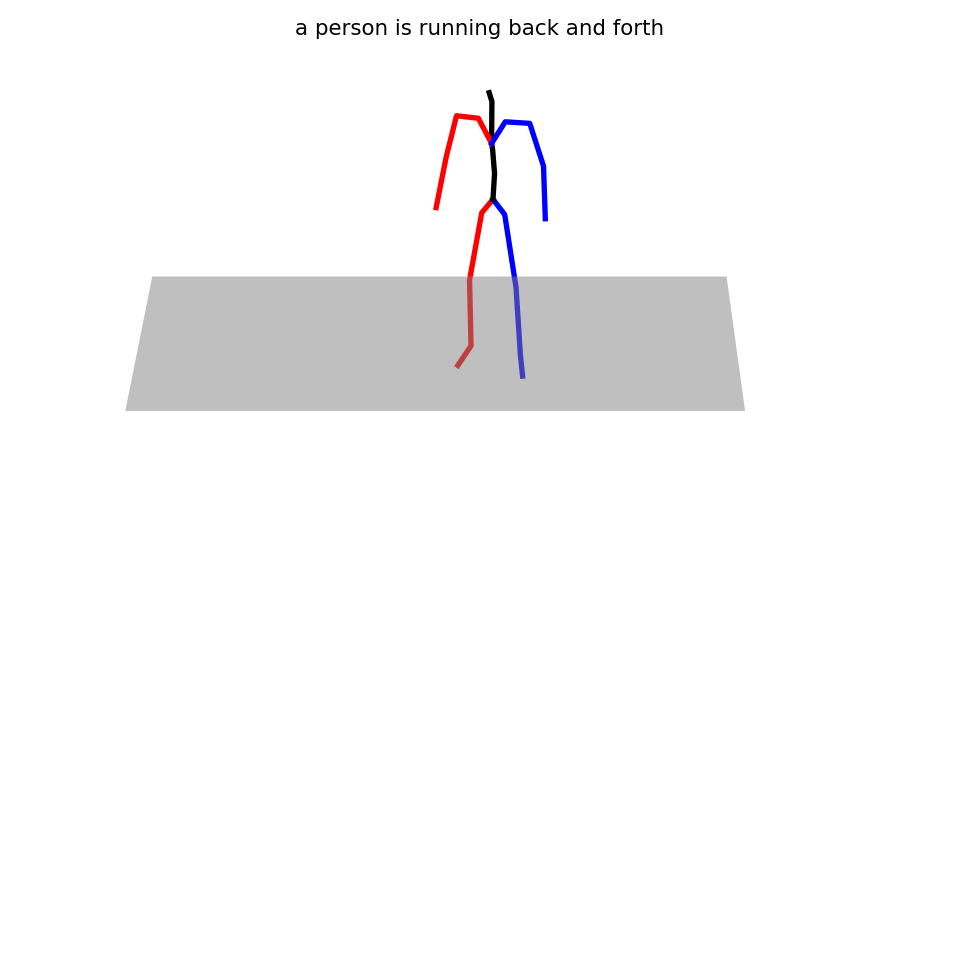

In [13]:
from IPython.display import HTML
import base64
b64 = base64.b64encode(open('example.gif','rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))